# Mask Detection using OpenCV

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2,os

data_path='/content/gdrive/MyDrive/Mask_Detection_using_OpenCV/Train'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [5]:
np.save('data',data)
np.save('target',new_target)

In [6]:
data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 40s 2s/step - loss: 0.7577 - accuracy: 0.4931 - val_loss: 0.6677 - val_accuracy: 0.5317
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/20
16/16 [==============================] - 38s 2s/step - loss: 0.6254 - accuracy: 0.6348 - val_loss: 0.6886 - val_accuracy: 0.5000
Epoch 3/20
16/16 [==============================] - 39s 2s/step - loss: 0.5758 - accuracy: 0.6926 - val_loss: 0.5286 - val_accuracy: 0.7540
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/20
16/16 [==============================] - 39s 2s/step - loss: 0.3890 - accuracy: 0.8506 - val_loss: 0.4567 - val_accuracy: 0.8016
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/20
16/16 [==============================] - 38s 2s/step - loss: 0.3185 - accuracy: 0.8905 - val_loss: 0.4078 - val_accuracy: 0.8413
INFO:tensorflow:Assets written to: model-005.model/assets
Epoch 6/20
16/16 [==============================] - 50s 3s/step - lo

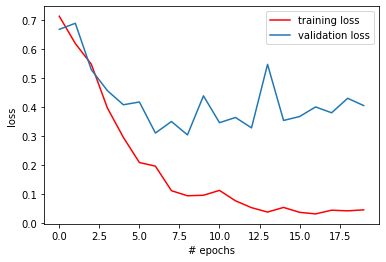

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

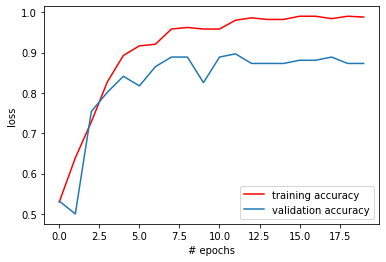

In [11]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
print(model.evaluate(test_data,test_target))

3/3 [==============================] - 1s 367ms/step - loss: 0.3178 - accuracy: 0.8857
[0.31778162717819214, 0.8857142925262451]


In [13]:
from keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [14]:
model = load_model('model-009.model')
 
face_clsfr=cv2.CascadeClassifier('/content/gdrive/MyDrive/Mask_Detection_using_OpenCV/haarcascade_frontalface_default.xml')
 
source=cv2.VideoCapture(0)
 
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):
 
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  
 
    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)
 
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2_imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

In [ ]:
import cv2
import numpy as np
 
cap = cv2.VideoCapture(0)
 
while(1):
 
    # Take each frame
    _, frame = cap.read()
 
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
 
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])
 
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
 
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
 
    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
 
cv2.destroyAllWindows()